# Simple Fixed Income Market

by Thomas Krabichler

## Packages

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

## Model Parameters

In [2]:
# TIME GRID

N=12*20
time_grid_plain=np.linspace(0,N,N+1)
time_grid_dcc=time_grid_plain/12 # day-count-convention

# BALANCE SHEET PARAMETERS

# assets
A0=100
# liabilities (constant deposits)
L0=50

# control the total swap volume
penalty=0.1

## Objective

In [3]:
# OPTIMISATION PARAMETERS
target_month=120

# loss function
target_equity=70

# size of training and validation set
nScenarios=10**3
nValidation=10**3

## Term Structure Model

In this section, we rely on historical ECB yield curve data. The mathematical framework of the Svensson parameterisation and the principal component analysis can be found in the Sections 3.3.3 - 3.4 of the textbook «Term Structure Models» by Damir Filipovic. Please be aware of Proposition 9.5 in the same book.

In [4]:
# YIELD CURVE PARAMETERS

index_yc=2135 # 31-Dec-2012

# YIELD CURVE DYNAMICS

# data import
path=''
ECB=pd.read_csv('201231_ECB.csv')

# zero-coupon bond prices for maturity T in years and Svensson parameter z
def ZCB_prices(T,z):
    return np.exp(-1/100*(z[0]*T-(z[1]/z[4]+z[2]/z[4]**2)*(np.exp(-z[4]*T)-1)-\
        z[2]/z[4]*T*np.exp(-z[4]*T)-z[3]/z[5]*T*np.exp(-z[5]*T)-z[3]/z[5]**2*\
        (np.exp(-z[5]*T)-1)))

# historical discount factors for a time grid
vec_ZCB_prices=np.vectorize(ZCB_prices,excluded=[1])

# yields for historical day i
def hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    shift=0 if rating=='AAA' else 6
    z=[ECB.loc[i,:][1+shift],ECB.loc[i,:][2+shift],ECB.loc[i,:][3+shift]/\
        ECB.loc[i,:][5+shift],ECB.loc[i,:][4+shift]/ECB.loc[i,:][6+shift],1/\
        ECB.loc[i,:][5+shift],1/ECB.loc[i,:][6+shift]]
    return np.divide(-np.log(vec_ZCB_prices(grid,z)),grid)

# collection of historical yields
def vec_hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    output=hist_yc(i[0],grid,rating)
    for j in i[1:]:
        output=np.vstack((output,hist_yc(j,grid,rating)))
    return output

# transform yields into discount factors
def discounting(yields,terms):
    return np.exp(-yields*terms)

# PCA
hist_increments=vec_hist_yc(range(1,index_yc))-vec_hist_yc(range(0,index_yc-1))
PCA_mu=np.mean(hist_increments,axis=0)
PCA_Q=np.cov(hist_increments,rowvar=False)
PCA_lambda,PCA_Lambda=np.linalg.eig(PCA_Q)
PCA_lambda,PCA_Lambda=np.real(PCA_lambda),np.real(PCA_Lambda)
#print(np.cumsum(PCA_lambda)[:10]/np.sum(PCA_lambda))

# generate a new yield curve increment
def yc_scn_gen(n = 3,PCA_mu=PCA_mu,PCA_Lambda=PCA_Lambda,PCA_lambda=PCA_lambda):
    return 22*PCA_mu+np.matmul(PCA_Lambda[:,:n],np.random.multivariate_normal(\
        np.zeros(n),np.diag(22*PCA_lambda[:n])).reshape(n,1)).flatten()

# YIELD CURVE OBJECTS

class yc:
    def __init__(self,yields):
        self.yields=yields
        self.dfs=discounting(yields,time_grid_dcc[1:])
    
    def cpn(self,tenor,maturity):
        return 12/tenor*(1-self.dfs[maturity-1])/np.sum(self.dfs[np.arange(\
            tenor,maturity+tenor,tenor)-1])
    
    def pv(self,cash_flows):
        return np.dot(self.dfs,cash_flows)
    
    def update(self,new_yields):
        self.yields=new_yields
        self.dfs=discounting(new_yields,time_grid_dcc[1:])

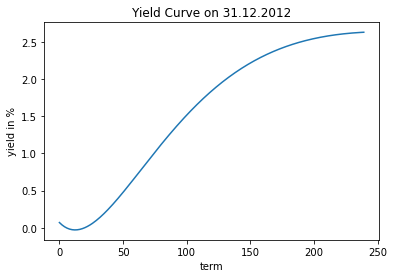

In [5]:
Y = yc(hist_yc(index_yc))
plt.plot(100*Y.yields)
plt.title('Yield Curve on '+ ECB.iloc[index_yc-1,0])
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

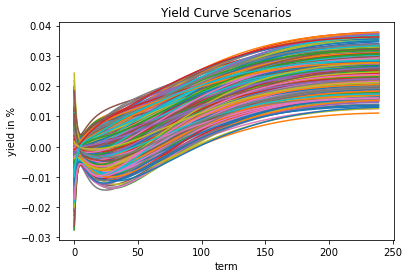

In [6]:
for k in range(int(1e3)):
    plt.plot(Y.yields+target_month*PCA_mu+np.matmul(PCA_Lambda[:,:3], np.random.multivariate_normal(np.zeros(3),np.diag(target_month*\
        PCA_lambda[:3])).reshape(3,1)).flatten())
plt.title('Yield Curve Scenarios')
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

## Swap Market

For simplicity, swap tenors in either legs are $1m$. The fixed leg is chosen such that swaps trade at par at issuance. E.g., see the section «Valuation of Interest Rate Swaps» in the textbook «Options, Futures,
and other Derivatives» by John C. Hull for further details.

In [291]:
swap_series=[24,60,120,240] # In this model we can only receive fixed and pay floating 

class swap:
    def __init__(self, yc, nominal, maturity, month_acquired=1): #tenor=1, month_index
        self.yc = yc
        self.nominal = nominal
        self.maturity = maturity
        self.fixed_leg = np.repeat(yc.cpn(1,self.maturity), self.maturity)/12
        self.month_acquired = month_acquired
        
    #def update(self, steps = 1):
    #    self.cash_flows = np.append(self.cash_flows[steps:],np.zeros(steps))

def swap_indicator(maturity):
    return np.reshape(np.append(np.ones(maturity),np.zeros(N-maturity)),(1,N))

In [292]:
Y = yc(hist_yc(index_yc))
s = swap(Y, nominal = 100, maturity = 24)
s1 = swap(Y, nominal = 100, maturity = 12)

## Benchmark Strategy of a Retail Bank

For the time being (and this can be relaxed), the deposits of the clients are kept constant and bear no interest. The asset side earns the monthly short rate. However, one could do better, if one incorporated swaps into the ecosystem. The current benchmark follows the strategy «doing nothing».

In [10]:
def benchmark(nRoutines=nValidation):
    output=np.zeros(nRoutines)
    for l in range(nRoutines):
        # yield curve
        Y=yc(hist_yc(index_yc))
        # assets
        A_pre=A0
        A_post=A0
        L=L0
        E=(A0-L0)
        for k in range(target_month):
            # market updates
            A_pre*=np.exp(Y.yields[0]/12)
            Y=yc(Y.yields+yc_scn_gen())
            A_post=A_pre
            L=L
            E=A_post-L
        output[l]=E
    return output

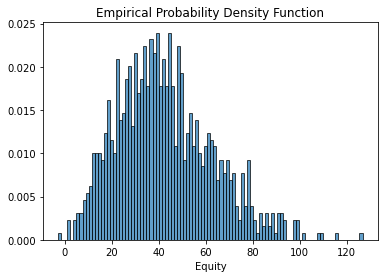

In [11]:
plt.hist(benchmark(), bins=100, density=True, edgecolor='black', alpha=0.7)
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()

I decided to tackle this problem using the Reinforcement Learning methodology. To proceed, it is usually useful to construct a "gym" environment https://gym.openai.com/docs/ from our given ALM environment setup. 


In [305]:
class ALMgym(gym.Env):

    def __init__(self, begin_index_yc, A0, L0, swaps_no, target_month):
        
        super(ALMgym, self).__init__()
        
        self.Y  = yc(hist_yc(begin_index_yc))
        self.begin_index_yc = begin_index_yc
        self.current_month = 0
        self.target_month = target_month
        
        self.A0 = A0
        self.L0 = L0
        
        self.swaps_no = swaps_no
        self.swaps = []
        self.swap_cash_flow = np.zeros(target_month)       
        
        # We will assume we can move any part of Assets and Liabilities with no transaction cost, and
        # that no penalty is endured for investing all of the liabilities - the latter part I will later include a penalty for
        
        l = [A0, L0]
        l.extend([0 for i in range(swaps_no)])
        
        self.initial_state = np.array(l, dtype = np.single)  # Initially no money is invested in any swap
        self.state = np.copy(self.initial_state)             # States and observations are synonmous in our model (full observability)
        
        self.action_space = spaces.Box(low = 0, high = (self.A0 + self.L0)/ 4, shape = (swaps_no,), dtype = np.single) 
        self.observation_space = spaces.Box(low = 0 , high = 1000, shape = (2 + swaps_no,), dtype=np.single)
        
        # In theory the assets accrued can go to infinity but actually we cap it at 1000 - I will explain this later
        # Position 1 in the observations = state array is assets other than swaps, position 2 in the array is liabilities, 
        # and the rest are the notional invested in each swap
        # We receive interest on assets but don't pay any interest on liabilities
        self.output = np.zeros(nValidation)

    def step(self, action):
                
        done   = False
        reward = 0
        info   = dict()

        if self.current_month == target_month:
            
            done = True
            # in the end want to release the nominal and add it back to assets
            self.state[0] += np.sum(self.state[2::])
            reward = self.state[0] - self.state[1]
            
            return np.copy(self.state), reward, done, info
            
        
        self.Y = yc(self.Y.yields + yc_scn_gen())    # update the yield curve
        
        self.state[0] *= np.exp(Y.yields[0]/12)      # Update the earnings due to interest on assets 
                        
        self.state[0] += self.swap_cash_flow[self.current_month]  # and collect the fixed rate due
        
        # Then pay floating for existing swaps
        
        for swp in self.swaps:
            
            # if the swap is still active
            if self.current_month < swp.month_acquired + swp.maturity:
                
                floating_owed = self.Y.cpn(tenor = 1, maturity = swp.month_acquired + swp.maturity - self.current_month)/12 * swp.nominal
                
                self.execute_transaction(floating_owed)
                
            else:
                
                # If the swap has expired then we can release the nominal and add it back to the assets
                self.state[0] += swp.nominal
                
                # Then check if we have the swap of the same type already
                swp_index = swap_series.index(swp.maturity)
                if self.state[swp_index] > 0:
                    
                    self.state[swp_index] -= swp.nominal
                    
                # Finally delete the swap from the list - this sometimes causes errors and I wasn't able to understand why
                try:
                    swaps.remove(swp)
                except:
                    pass
                
        
        # If at any point the liabilities drop to below 10% of the initial value, the game is over
        if self.state[1] < self.L0 * penalty:
            
            #self.reset()
            done = True
            reward = -300       # arbitrary large negative constant
            
        # Now enter new swaps agreements determined by the action

        for i in range(len(action)):
            
            if action[i] != 0.0:
                
                new_swap = swap(self.Y, nominal = action[i], maturity = swap_series[i], month_acquired = self.current_month)
                
                # No transaction cost modeled yet - we use assets or liabilities to invest the nominal in the swap,
                # Which is then locked in and can't be further lent out to get interest on
                
                self.execute_transaction(action[i])
                self.swaps.append(new_swap) 
                                
                maturity_end_month = min(self.current_month + new_swap.maturity, self.target_month)
                                
                self.swap_cash_flow[self.current_month:maturity_end_month] += new_swap.fixed_leg[0:(maturity_end_month - self.current_month)] * new_swap.nominal

                            
        # Finally update the state by incremenenting by the nominal invested in the new swaps:
        self.state[2::] = self.state[2::] + action
        
        if not done:
            
            reward = self.state[0] - self.state[1]
            
        self.output[self.current_month] = reward
        
        self.current_month += 1
        
        self.action_space.high = np.repeat((self.state[0] + self.state[1] * (1-penalty)) / self.swaps_no, self.swaps_no)
        
        return np.copy(self.state), float(reward), done, info 
        
    
    # Uses first the assets to cover the cost of amount_due, otherwise uses liabilities 
    def execute_transaction(self, amount_due):
        
        if self.state[0] - amount_due > 0:
                    
            self.state[0] -= amount_due

        else:

            # If there are no assets left use liabilities = deposit money
            self.state[1] -= amount_due
        
        
    
    # Reset the state of the environment to the initial state
    def reset(self):
        
        self.Y  = yc(hist_yc(self.begin_index_yc))
        self.state = np.copy(self.initial_state)
        self.swap_cash_flow = np.zeros(target_month)
        self.current_month = 0
        self.swaps = []
        self.action_space.high = np.repeat((self.A0 + self.L0 * (1-penalty)) / self.swaps_no, self.swaps_no)
        
        return np.copy(self.initial_state)


To clarify:
1. No rates exchange place until 1m of the deal?
2. Once we receive the cash from the swaps can we add it back to the assets to get interest on it? 
3. Round actions and states to 2 decimals for niceness purposes 

First we test whether the env is set up correctly by initiating a random agent

In [306]:
env = ALMgym(index_yc, A0, L0, len(swap_series), target_month)

state  = np.copy(env.initial_state)
output = np.zeros(nValidation)

In [307]:
check_env(env) # Very useful method checking whether your custom envirnoment fits the stable_baselines3 blueprint

In [308]:
env.reset()
for k in range(target_month):
    
    action = np.around(env.action_space.sample(), 2) # just take random action = investing arbitrary nominal in arbitrary asset
    next_state, reward, done, info = env.step(action)
    print(observation_space.contains(np.around(next_state, 2)))
    if done:
        
        print("You have lost the game in month " , k)
        break
        
    else:
        
        print("--------")
        print("State", state)
        print("Action", action)
        print("Next State", next_state)
        print("Reward", reward)
        print("Liquidable", env.action_space.high)
        print("--------")
        state = next_state
    

True
--------
State [100.  50.   0.   0.   0.   0.]
Action [17.65  0.05  2.08 12.2 ]
Next State [6.802589e+01 5.000000e+01 1.765000e+01 5.000000e-02 2.080000e+00
 1.220000e+01]
Reward 18.02588653564453
Liquidable [28.25647163 28.25647163 28.25647163 28.25647163]
--------
True
--------
State [6.802589e+01 5.000000e+01 1.765000e+01 5.000000e-02 2.080000e+00
 1.220000e+01]
Action [27.73 25.28  7.38 12.69]
Next State [ 7.6418753 37.31      45.379997  25.33       9.46      24.89     ]
Reward -29.66812515258789
Liquidable [10.30521913 10.30521913 10.30521913 10.30521913]
--------
True
--------
State [ 7.6418753 37.31      45.379997  25.33       9.46      24.89     ]
Action [2.64 2.76 2.01 7.74]
Next State [ 0.23463964 29.570002   48.019997   28.09       11.47       32.629997  ]
Reward -29.33536148071289
Liquidable [6.71191027 6.71191027 6.71191027 6.71191027]
--------
True
--------
State [ 0.23463964 29.570002   48.019997   28.09       11.47       32.629997  ]
Action [3.45 1.21 4.61 1.03]
Ne

In [309]:
env.reset()
n_actions = env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.repeat(0, n_actions), sigma=10 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=50_000, log_interval=1000)
model.save("ddpg_alm")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.88     |
|    ep_rew_mean     | -414     |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 53       |
|    time_elapsed    | 146      |
|    total timesteps | 7780     |
| train/             |          |
|    actor_loss      | 319      |
|    critic_loss     | 51.7     |
|    learning_rate   | 0.001    |
|    n_updates       | 7680     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.23     |
|    ep_rew_mean     | -397     |
| time/              |          |
|    episodes        | 2000     |
|    fps             | 53       |
|    time_elapsed    | 285      |
|    total timesteps | 15179    |
| train/             |          |
|    actor_loss      | 317      |
|    critic_loss     |

In [310]:
env.reset()
state  = np.copy(env.initial_state)
output = np.zeros(nValidation)
print("initial state", state)

for k in range(target_month):
    
    action = model.predict(state) 
    next_state, reward, done, info = env.step(action[0])
    
    if done:
        
        print("You have lost the game in month " , k)
        break
        
    else:
        
        print("--------")
        print("State", state)
        print("Action", action)
        print("Next State", next_state)
        print("Reward", reward)
        print("--------")
        state = next_state

    
    

initial state [100.  50.   0.   0.   0.   0.]
--------
State [100.  50.   0.   0.   0.   0.]
Action (array([ 0.  , 36.25, 36.25,  0.  ]), None)
Next State [27.50589 50.       0.      36.25    36.25     0.     ]
Reward -22.494110107421875
--------
--------
State [27.50589 50.       0.      36.25    36.25     0.     ]
Action (array([ 0.        , 18.12647247, 18.12647247,  0.        ]), None)
Next State [ 9.404699 31.873528  0.       54.376472 54.376472  0.      ]
Reward -22.468828201293945
--------
--------
State [ 9.404699 31.873528  0.       54.376472 54.376472  0.      ]
Action (array([0.        , 9.52271852, 9.52271852, 0.        ]), None)
Next State [ 9.411426 12.828091  0.       63.899193 63.899193  0.      ]
Reward -3.4166650772094727
--------
--------
State [ 9.411426 12.828091  0.       63.899193 63.899193  0.      ]
Action (array([0.       , 5.2391768, 5.2391768, 0.       ]), None)
Next State [ 4.168167  7.588914  0.       69.13837  69.13837   0.      ]
Reward -3.42074680328369